## 1. Setup

Run this cell first to enable the interactive matplotlib backend (`ipympl`) and import all necessary libraries.

**Note:** You must have the following installed in your environment:
```bash
uv pip install jupyterlab matplotlib ipywidgets ipympl tifffile numpy ipyfilechooser

In [7]:
%matplotlib widget

import tifffile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector, SpanSelector
import ipywidgets as widgets
from pathlib import Path
import json
from ipyfilechooser import FileChooser  # Import the file chooser

# This global dictionary will hold the state between cells
app_state = {}

print("Libraries loaded. Ready for Step 1.")

Libraries loaded. Ready for Step 1.


## 2. Step 1: Select Input Folder

1.  Use the widget to navigate to and select your `Input_TIFFS` folder.
2.  Run **Step 2** to load the data.

In [9]:
# --- Create the directory chooser ---
# This is set up to only select directories
dir_chooser = FileChooser(
    path="/Users/minesbioimaging/dev/PixelPacker/Input_TIFFS",  # Starting path
    show_hidden=False,
    select_default=True,
    show_only_dirs=True,
    title="<b>Select your Input_TIFFS folder:</b>",
)
display(dir_chooser)

FileChooser(path='/Users/minesbioimaging/dev/PixelPacker/Input_TIFFS', filename='', title='<b>Select your Inpu…

## 3. Step 2: Load Data & Generate MIPs

Click the button to scan the folder, load the first `_ch0` file, and generate the MIPs.

In [ ]:
out_log = widgets.Output(
    layout={"border": "1px solid black", "max_height": "150px", "overflow": "scroll"}
)


def load_data_and_mips(b):
    out_log.clear_output()
    with out_log:
        try:
            # Get the path from the file chooser widget
            folder_path_str = dir_chooser.value
            if not folder_path_str:
                print(
                    "❌ ERROR: No directory selected. Please select a folder in Step 1."
                )
                return

            folder_path = Path(folder_path_str)
            if not folder_path.is_dir():
                print(f"❌ ERROR: Path is not a directory: {folder_path}")
                return

            print(f"Scanning {folder_path}...")
            ch0_file = next(folder_path.glob("*_ch0_stack*.tif*"), None)

            if not ch0_file:
                print("❌ ERROR: No '*_ch0_stack*.tif*' file found.")
                return

            print(f"Loading {ch0_file.name}...")
            data = tifffile.imread(ch0_file).squeeze()

            if data.ndim != 3:
                print(
                    f"❌ ERROR: Squeezed data is not 3D (Z,Y,X). Shape is {data.shape}"
                )
                return

            # Save all data to the global state
            app_state["folder_path"] = folder_path
            app_state["data_shape"] = data.shape
            app_state["mip_xy"] = np.max(data, axis=0)
            app_state["mip_xz"] = np.max(data, axis=1)
            app_state["crop_coords"] = {
                "start_z": 0,
                "end_z": data.shape[0],
                "start_y": 0,
                "end_y": data.shape[1],
                "start_x": 0,
                "end_x": data.shape[2],
            }

            print(f"✅ Success! Load complete. Shape: {data.shape} (Z,Y,X)")
            print("Ready to run Step 3.")

        except Exception as e:
            print(f"❌ An unexpected error occurred: {e}")


load_button = widgets.Button(description="Load Data & Generate MIPs")
load_button.on_click(load_data_and_mips)
display(widgets.VBox([load_button, out_log]))

## 4. Step 3: Define Crop Regions

Run this cell to display the interactive plots.

1.  **On the left (XY-MIP):** Click and drag to draw a **yellow rectangle** for your X-Y crop.
2.  **On the right (XZ-MIP):** Click and drag *vertically* to create a **cyan span** for your Z-crop.
3.  Run **Step 4** when finished.

Selectors active. Draw on plots to define regions.
Run Step 4 when finished.


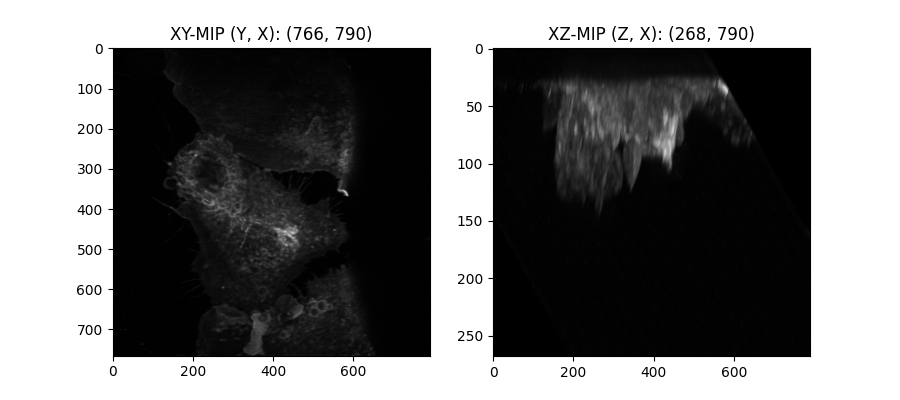

In [14]:
# Check if data is loaded first
if "mip_xy" not in app_state:
    print("❌ ERROR: 'app_state' not found. Please run Step 2 to load data first.")
else:
    print("Selectors active. Draw on plots to define regions.")
    print("Run Step 4 when finished.")

    fig, (ax_xy, ax_xz) = plt.subplots(1, 2, figsize=(9, 4))
    fig.canvas.header_visible = False

    # --- Plot MIPs ---
    ax_xy.imshow(app_state["mip_xy"], aspect="equal", cmap="gray")
    ax_xy.set_title(f"XY-MIP (Y, X): {app_state['mip_xy'].shape}")
    ax_xz.imshow(app_state["mip_xz"], aspect="auto", cmap="gray")
    ax_xz.set_title(f"XZ-MIP (Z, X): {app_state['mip_xz'].shape}")

    # --- Callbacks ---
    def on_xy_select(eclick, erelease):
        x1, x2 = sorted([int(eclick.xdata), int(erelease.xdata)])
        y1, y2 = sorted([int(eclick.ydata), int(erelease.ydata)])
        app_state["crop_coords"]["start_x"] = x1
        app_state["crop_coords"]["end_x"] = x2
        app_state["crop_coords"]["start_y"] = y1
        app_state["crop_coords"]["end_y"] = y2
        print(f"Crop set to: X=[{x1}, {x2}], Y=[{y1}, {y2}]")

    def on_z_select(zmin, zmax):
        z1, z2 = sorted([int(zmin), int(zmax)])
        app_state["crop_coords"]["start_z"] = z1
        app_state["crop_coords"]["end_z"] = z2
        print(f"Crop set to: Z=[{z1}, {z2}]")

    # --- Activate Selectors ---
    # These variables MUST be kept in scope (assigned to a var)
    xy_selector = RectangleSelector(
        ax_xy,
        on_xy_select,
        useblit=True,
        props=dict(facecolor="yellow", alpha=0.3),
        interactive=True,  # <-- ADDED: This keeps the rectangle visible
    )
    z_selector = SpanSelector(
        ax_xz,
        on_z_select,
        "vertical",
        useblit=True,
        props=dict(facecolor="cyan", alpha=0.3),
        drag_from_anywhere=True,
        interactive=True,  # <-- ADDED: This keeps the span visible
    )

    plt.show()

## 5. Step 4: Save Configuration File

Run this cell, then click the button to save the `config.json` file (with the coordinates you just drew) into your `Input_TIFFS` folder.

In [ ]:
save_button = widgets.Button(description="Save config.json")
save_log = widgets.Output(
    layout={"border": "1px solid black", "max_height": "200px", "overflow": "scroll"}
)

def on_save_button_clicked(b):
    save_log.clear_output()
    with save_log:
        if "folder_path" not in app_state:
            print("❌ ERROR: No data loaded. Please run Step 2 first.")
            return

        c = app_state["crop_coords"]
        if (
            c["start_z"] >= c["end_z"]
            or c["start_x"] >= c["end_x"]
            or c["start_y"] >= c["end_y"]
        ):
            print("❌ ERROR: Invalid crop range. Start must be less than end.")
            print(f"Current values: {c}")
            return

        output_config = {
            "input_dir": str(app_state["folder_path"]),
            "output_dir": str(app_state["folder_path"].parent / "Cropped_Output"),
            "start_z": c["start_z"],
            "end_z": c["end_z"],
            "start_x": c["start_x"],
            "end_x": c["end_x"],
            "start_y": c["start_y"],
            "end_y": c["end_y"],
            "workers": 12,
        }

        out_path = app_state["folder_path"] / "config.json"
        try:
            with open(out_path, "w") as f:
                json.dump(output_config, f, indent=2)
            print(f"✅ Success! Saved config to: {out_path}")
            print("---")
            print(json.dumps(output_config, indent=2))
        except Exception as e:
            print(f"❌ Error saving file: {e}")


save_button.on_click(on_save_button_clicked)
display(widgets.VBox([save_button, save_log]))

In [19]:
import sys

print("--- Starting Cropping Script ---")

try:
    # Check if the config file path is in memory
    if "folder_path" not in app_state:
        print("❌ ERROR: 'folder_path' not found. Please run Step 2 & 4 first.")
    else:
        # Construct the path to the config file
        config_path = app_state["folder_path"] / "config.json"
        
        if not config_path.exists():
            print(f"❌ ERROR: Config file not found at {config_path}")
            print("   Please run Step 4 to save the file.")
        else:
            # Construct the full command
            # REMOVED the "tiff_cropper/" prefix from the script path
            command = f"uv run python crop_tool.py -c {config_path}"
            print(f"Executing: {command}\n")
            
            # --- Execute the shell command ---
            # This will run the command in your system's terminal
            # The output (including progress bars) will appear below.
            !{command}
            
            print("\n--- Cropping Script Finished ---")

except NameError:
    print("❌ ERROR: 'app_state' not defined. Please run all previous steps.")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}", file=sys.stderr)

--- Starting Cropping Script ---
Executing: uv run python crop_tool.py -c /Users/minesbioimaging/dev/PixelPacker/Input_TIFFS/config.json

2025-11-07 16:18:00 - INFO - --- TIFF Cropping Tool Started ---
2025-11-07 16:18:00 - INFO - Loaded configuration from: /Users/minesbioimaging/dev/PixelPacker/Input_TIFFS/config.json
Loaded configuration from: /Users/minesbioimaging/dev/PixelPacker/Input_TIFFS/config.json
2025-11-07 16:18:00 - INFO - Using input directory from config file: /Users/minesbioimaging/dev/PixelPacker/Input_TIFFS
2025-11-07 16:18:00 - INFO - Using output directory from config file: /Users/minesbioimaging/dev/PixelPacker/Cropped_Output
2025-11-07 16:18:00 - INFO - Effective parameters: Input='/Users/minesbioimaging/dev/PixelPacker/Input_TIFFS', Output='/Users/minesbioimaging/dev/PixelPacker/Cropped_Output', Stack/Z=[15:158), X=[92:641), Workers=12
2025-11-07 16:18:00 - INFO - Ensured output directory exists: /Users/minesbioimaging/dev/PixelPacker/Cropped_Output
2025-11-07 16